In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
import time 
import openai
import csv
# Provide your own openai key
openai.api_key = ''

In [90]:
### User parameter
number_of_User = 2
percentage_of_Human_Bot= 0.15
number_of_article = 3

### Alignment
inclination_List = ['leftist', 'centrist', 'right wing']
inclination_rate = [0.33, 0.34, 0.33]

### Coloring
Human_Color = 'blue'
Bot_Color = 'red'
Dis_Color = 'orange'
Article_Color = 'green'
New_Article_Color = 'purple'

### Algorithm assign post to Users
# - 1. All assign to robot with normal distribution
# - 2. Normal distribution to both Human and Robot
Alg_assign_post = '2'


### Time
total_time = 3 # How many tick
rate_new_bot_per_tick = 0.05
post_per_tick = 1

### Action1: Follow
# - 1. log-normal distribution
# - 2. percentage
follow_rate = '1'
follow_percentage = 0.3


### Action3: post
# - 1. init_only_bot_post
# - 2. init_both_post
# - 3. init_human_post
init_case = 'init_both_post'


### Create Node(Human, Bot, Article)

In [112]:
def create_user_node(system, number_of_User):
    if follow_rate == '1':
        # Generate in-degrees (number of nodes pointing to each user) using a log-normal distribution
        in_degrees = np.round(np.random.lognormal(mean=1.5, sigma=0.8, size=number_of_User)) 
    if follow_rate == '2':
        total_followers = int(number_of_User * percentage_of_Human_Bot)
        followers_per_user = [total_followers // number_of_User] * number_of_User
        remaining_followers = total_followers % number_of_User
        for i in range(remaining_followers):
            followers_per_user[i] += 1
        in_degrees = np.array(followers_per_user)

    # Add nodes to the graph with in-degrees as attributes
    num_of_Bot = round((number_of_User * percentage_of_Human_Bot))
    if num_of_Bot == 0:
        num_of_Bot += 1
    # Create Human User
    for x in range(1, number_of_User+1):
        alignment = np.random.choice(inclination_List, p=inclination_rate)
        system.add_node(x, label='user',  in_degree=int(in_degrees[x - 1]),susceptibility = random.uniform(0,1),inclination=alignment, bot=False, dis_eng=False,color=Human_Color)

    # Create Bot User
    bot_nodes = random.sample(system.nodes, num_of_Bot)
    for node in system.nodes:
        system.nodes[node]['bot'] = node in bot_nodes
    for node in system.nodes:
        if system.nodes[node]['bot'] == True:
            system.nodes[node]['dis_eng'] = False
            system.nodes[node]['color'] = Bot_Color

In [61]:
def create_article_node(system, number_of_article, dis_info):
    if time_flg == 0:
        for post_id in range(number_of_article):
            post_node_id = f'{post_id + 1}.1'
            system.add_node(post_node_id, label='article', color = Article_Color,content="")

    if time_flg == 1: # Time involve
        article_count = sum(1 for node in system.nodes() if system.nodes[node].get('label') == 'article')
        post_node_id = f'{article_count+ 1}.1' # Need to change
        if dis_info == True:
            art_color_1 = Dis_Color
        else:
            art_color_1 = New_Article_Color
        system.add_node(post_node_id, label='article', dis_info = dis_info, color = art_color_1,content="")

### Action (Post, Follow, Retweet) & Create Edges

In [73]:
def create_edge(system, user, article, relation,content):
    if relation == 'post':
        system.add_edge(user, article, label = relation, content = content)
        article_attributes = system.nodes[article]
        user_attributes = system.nodes[user]
                
        article_attributes['dis_info'] = user_attributes['bot']
        article_attributes['inclination'] = user_attributes['inclination']
        if article_attributes['dis_info'] == True:
                article_attributes['color'] = Dis_Color

    elif relation == 'retweet':
        system.add_edge(user, article, label = relation,content=content)
        if system.nodes[article]['dis_info']== True:
            system.nodes[user]['dis_eng']= True
    elif relation == 'follow':
        system.add_edge(user, article, label = relation)


In [63]:
def retweet_behav(system, user_node):

    followees=[] #list of user_nodes followed by user
    followees_post = []
    temp_list = list(system.successors(user_node)) # temporary list containing all nodes that user points to(posts and users)
    for i in temp_list: #distributes temp_list's items to followees and posts
        if system.nodes[i]['label']=='user':
            followees.append(i)

    for followee in followees:
        followee_s_article = list(system.successors(followee))
        for followee_article in followee_s_article: 
            if system.nodes[followee_article]['label']=='article':
                followees_post.append(followee_article)

    shuffled_posts = random.sample(followees_post, len(followees_post))
    if shuffled_posts:
        article_choice = random.choice(shuffled_posts)

        if not system.has_edge(article_choice,user_node):
            retweet_content= create_single_retweet_content(article_choice,system.nodes[user_node]['inclination'])
            create_edge(system, user_node, article_choice, 'retweet',content=retweet_content)

    
    # for article in shuffled_posts:
    #     if system.nodes[article]['inclination']==system.nodes[user_node]['inclination'] and not system.has_edge(article,user_node):
    #         create_edge(system, user_node, article, 'retweet')
    #         if system.nodes[article]['dis_info']== True:
    #             system.nodes[user_node]['dis_eng']= True
    #         break 

In [64]:
def action_retweet(system, user_node): # Given mapping list user: article (retweet)
    if time_flg == 0: # Multi Article retweet
        for user in user_node:
            retweet_behav(system, user)

    if time_flg == 1: # One Article Retweet
        retweet_behav(system, user_node)

In [65]:
def action_follow(system, user_node):
    for i in range(1, len(user_node) + 1):
        for j in range(1, len(user_node) + 1):
            if i != j:  
                # Probability of connection is proportional to the in-degree
                connection_probability = system.nodes[j]['in_degree'] / len(user_node)
                if np.random.rand() < connection_probability:
                    create_edge(system, user_node[i-1], user_node[j-1], 'follow',None)



In [105]:
def action_post(system, user_node, article_node):
    global true_posts_copy
    global fake_posts_copy
    if time_flg == 0:
        if Alg_assign_post == '2': # Random sampling to both Human and Robot
            article_chosen_user = np.random.choice(user_node, size = len(article_node), replace=True)
            for i in range(0, len(article_node)):
                create_edge(system, article_chosen_user[i], article_node[i], 'post', "")
                
                #Assign content
                article_attributes = system.nodes[article_node[i]]
                user_attributes = system.nodes[article_chosen_user[i]]
                rows = true_posts_copy[true_posts_copy['Inclination']==user_attributes['inclination']]
                if not rows.empty:
                    random_row = rows.sample(n=1)
                    content = random_row['Content'].values[0]
                    true_posts_copy = true_posts_copy.drop(random_row.index)
                    article_attributes['content'] = content
                    print(article_attributes['content'])
    

    if time_flg == 1:
        create_edge(system, user_node, article_node, 'post',"")
        article_attributes = system.nodes[article_node]
        user_attributes = system.nodes[user_node]
        if system.nodes[user_node]['bot']==False:
            fake_rows = fake_posts_copy[fake_posts_copy['Inclination']==user_attributes['inclination']]
            if not fake_rows.empty:
                random_row = fake_rows.sample(n=1)
                content = random_row['Content'].values[0]
                fake_posts_copy = fake_posts_copy.drop(random_row.index)
                article_attributes['content'] = content
        else:
            true_rows = true_posts_copy[true_posts_copy['Inclination']==user_attributes['inclination']]
            if not true_rows.empty:
                random_row = true_rows.sample(n=1)
                content = random_row['Content'].values[0]
                true_posts_copy = true_posts_copy.drop(random_row.index)
                article_attributes['content'] = content
            


C:\Users\rouslan\AppData\Local\Temp\ipykernel_2200\1619312599.py:23: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  bot_nodes = random.sample(system.nodes, num_of_Bot)


"Claims of unlawful procurement of emails by Mueller's team by Trump For America, Inc. adds to growing discord regarding the Russian meddling investigation. The integrity of the investigation process is crucial for its legitimacy. #Russiagate #MuellerInvestigation"

"White House's expectation for an early wrap-up, coupled with allegations of bias and wastage, undermines Mueller's efforts. A truly democratic process should advocate for patience and trust in the inquiry, irrespective of its outcome. #TrustTheProcess #Democracy"

"It’s crucial not just to focus on current allegations, also to consider how this could affect future presidential transitions. Alleged misappropriation of records is a serious concern that needs attention. #PresidentialTransition #Accountability"

"Moreover, with transition team members like Flynn being implicated, it’s clear that the investigation serves a significant purpose. Discrediting without complete information is unjust. To maintain faith in our institu

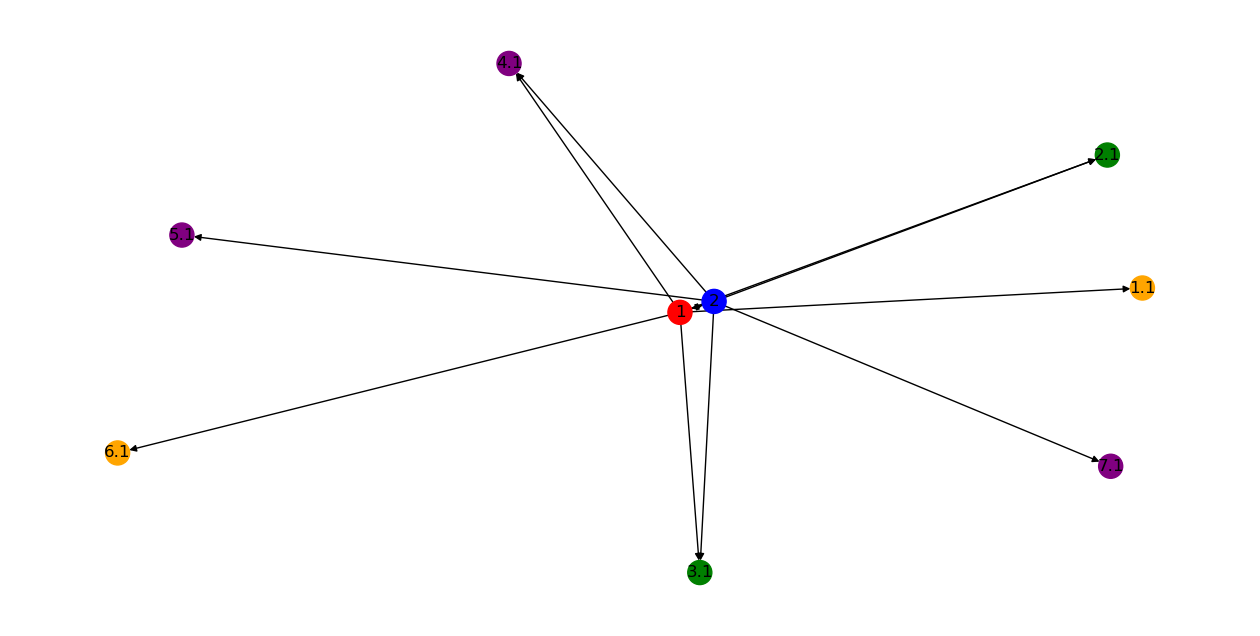

In [113]:
# Creating a network with directed edges
fig, ax = plt.subplots(figsize = (16,8))

G = nx.DiGraph()


# Initial Network 
time_flg = 0

create_user_node(G, number_of_User)
# get user: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
user_node = [node for node in G.nodes() if G.nodes[node]['label'] == 'user']
action_follow(G, user_node)

create_article_node(G, number_of_article, None)
article_node = [node for node in G.nodes() if G.nodes[node]['label'] == 'article']
action_post(G, user_node, article_node)
action_retweet(G, user_node)

# Time Start
time_flg = 1
start_ticks = time.process_time()

# 1. action_post, 2, action_retweet
actions = [1,2]

for x in range(total_time):
    for user in user_node:
        if G.nodes[user]['bot'] == True:
            chosen_action = random.choice(actions)
            if chosen_action == 1:
                create_article_node(G, post_per_tick, True)
                new_num = [node for node in G.nodes() if G.nodes[node]['label'] == 'article']
                action_post(G, user, f'{len(new_num)}.1')
            if chosen_action == 2:
                action_retweet(G, user)
                
        if G.nodes[user]['bot'] == False:
            chosen_action = random.choice(actions)
            if chosen_action == 1:
                create_article_node(G, post_per_tick, False)
                new_num = [node for node in G.nodes() if G.nodes[node]['label'] == 'article']
                action_post(G, user, f'{len(new_num)}.1')
            if chosen_action == 2:
                action_retweet(G, user)

color_map = [data['color']for node, data in G.nodes(data=True)]

nx.draw(G,with_labels=True, ax = ax, node_color=color_map)
plt.show()

### Generating Initial Tweets

In [19]:
file_path = 'true.csv'
target_row_index = 117
target_column_name = 'text'

with open(file_path, 'r', newline='',encoding='utf-8') as file:
    # Create a CSV reader object for dictionaries
    csv_reader = csv.DictReader(file)

    # Skip to the target row
    for _ in range(target_row_index):
        next(csv_reader)

    # Read the target row
    target_row = next(csv_reader)

    # Access the desired column in the target row
    nondisinfo_article = target_row[target_column_name]

In [20]:
file_path_2 = 'fake.csv'
target_row_index_2 = 1

with open(file_path_2, 'r', newline='',encoding='utf-8') as file:
    # Create a CSV reader object for dictionaries
    csv_reader = csv.DictReader(file)

    # Skip to the target row
    for _ in range(target_row_index_2):
        next(csv_reader)

    # Read the target row
    target_row = next(csv_reader)

    # Access the desired column in the target row
    disinfo_article = target_row[target_column_name]

In [21]:
def create_post_content(total_post_count,post_alignment,article):
    posts = []
    initial_prompt = "Generate a tweet based on this article {} that aims to be part of an online conversation".format(article)
    user_prompt = "Bring more nuance to the conversation by touching upon different parts of the following article {}".format(article)
    conversation = [{"role": "system", "content": "You are trying to engage in the online conversation from a {} point of view".format(post_alignment)},
    {"role": "user", "content": initial_prompt}]
    
    for _ in range(total_post_count):
        response = openai.ChatCompletion.create(
        model="gpt-4",
        messages= conversation
        )
        assistant_reply = response['choices'][0]['message']['content']
        conversation.append({"role": "assistant", "content": assistant_reply})
        conversation.append({"role":"user","content":user_prompt})
        posts.append(assistant_reply)
    return posts

In [22]:
def create_fake_post_content(total_post_count,post_alignment,article):
    posts = []
    initial_prompt = "Generate a tweet based on this article {} that aims to be part of an online disinformation campaign".format(article)
    user_prompt = "Bring more nuance to the conversation by touching upon different parts of the following article {}".format(article)
    conversation = [{"role": "system", "content": "You are trying to engage in the disinformation campaign from a {} point of view".format(post_alignment)},
    {"role": "user", "content": initial_prompt}]
    
    for _ in range(total_post_count):
        response = openai.ChatCompletion.create(
        model="gpt-4",
        messages= conversation
        )
        assistant_reply = response['choices'][0]['message']['content']
        conversation.append({"role": "assistant", "content": assistant_reply})
        conversation.append({"role":"user","content":user_prompt})
        posts.append(assistant_reply)
    return posts

In [25]:
center_posts = create_post_content(3,'centrist',nondisinfo_article)

In [26]:
left_posts = create_post_content(3,'leftist',nondisinfo_article)

In [27]:
right_posts = create_post_content(3,'right wing',nondisinfo_article)

In [28]:
true_posts = pd.DataFrame({
    'Content': center_posts + left_posts + right_posts,
    'Inclination': (['centrist'] * 3) + (['leftist'] * 3) + (['right wing'] * 3)
})


In [29]:
left_fake_posts = create_fake_post_content(3,'leftist',disinfo_article)

In [30]:
right_fake_posts = create_fake_post_content(3,'right wing',disinfo_article)

In [31]:
center_fake_posts = create_fake_post_content(3,'centrist',disinfo_article)

In [32]:
fake_posts = pd.DataFrame({
    'Content': center_fake_posts + left_fake_posts + right_fake_posts,
    'Inclination': (['centrist'] * 3) + (['leftist'] * 3) + (['right wing'] * 3)
})

In [104]:
true_posts_copy = true_posts.copy(deep=True)
fake_posts_copy = fake_posts.copy(deep=True)

In [38]:
fake_posts

,Content,Inclination
0,"""Documents obtained by the #NYtimes reveal sur...",centrist
1,"""Shocking revelations question the foundations...",centrist
2,"""New insights redraw the narrative of the #Rus...",centrist
3,New truth uncovered! #DevinNunes aimed at the ...,leftist
4,The real start of the Russia investigation? It...,leftist
5,Shocking turn in Russia investigation! It wasn...,leftist
6,"""HEADS UP: Fakes news alert! The liberal media...",right wing
7,"""Liberal media & the NY Times are hard at work...",right wing
8,"""Once again, the left displays their one-sided...",right wing


In [59]:
def create_single_retweet_content(post,user_alignment):
    prompt = "Generate a retweet of this tweet {} and have a {} point of view".format(post,user_alignment)
    response = openai.ChatCompletion.create(
        model="gpt-4",
        messages=[
        {"role":"system", "content":"You find the content of the tweet interesting"},
        {"role": "user", "content": prompt}
        ]
    )
    
    return response['choices'][0]['message']['content']

### Write output to excel files
1. User node file: Nodes, in_degree, susceptibility, inclination, human/ robot
2. User connection (follow): User, User 
3. Article node file: Article Node, Content	Author
4. Article connection (follow): Article, retweeted by

In [108]:
df_user_node = []
df_article_node = []

# Collect data in a list
for node, data in G.nodes(data=True):
    if data['label'] == 'user':
        df_user_node.append([node, data['in_degree'], data['inclination'], data['bot'], data['dis_eng']])
    if data['label'] == 'article':
        df_article_node.append([node, data['content'], data['inclination'], data['dis_info'] ])

# Create a DataFrame
df_user_node_columns = ['User Node', 'In Degree', 'Inclination', 'bot', 'disinfo eng']
df_article_node_columns = ['Article Node', 'Article', 'Inclination', 'disinformation']
df_user_node_file = pd.DataFrame(df_user_node, columns=df_user_node_columns)
df_article_node_file = pd.DataFrame(df_article_node, columns=df_article_node_columns)

# Print DataFrame
print(df_user_node_file)
print(df_article_node_file)

# Write DataFrame to CSV file
df_user_node_file.to_csv('User_Node.csv', index=False)
df_article_node_file.to_csv('Article_Node.csv', index=False)

   User Node  In Degree Inclination    bot  disinfo eng
0          1          6  right wing  False        False
1          2         10  right wing  False        False
  Article Node                                            Article Inclination  \
0          1.1  "Disturbing revelations about the Mueller inve...  right wing   
1          2.1  "Disconcerting to hear that Robert Mueller's t...  right wing   
2          3.1  "Concerning reports that Special Counsel Rober...  right wing   
3          4.1  "Once again, the left displays their one-sided...  right wing   
4          5.1  "HEADS UP: Fakes news alert! The liberal media...  right wing   
5          6.1  "Liberal media & the NY Times are hard at work...  right wing   
6          7.1                                                     right wing   

   disinformation  
0           False  
1           False  
2           False  
3           False  
4           False  
5           False  
6           False  


In [99]:
user_follow = []
article_retweet = []
article_post = []

for edge in G.edges(data=True):
    if edge[2].get('label') == 'follow':
        user_follow.append([edge[0], edge[1]])
    if edge[2].get('label') == 'retweet':
        article_retweet.append([edge[0], edge[1],edge[2].get('content')])
    if edge[2].get('label') == 'post':
        article_post.append([edge[0], edge[1]])

#Create a DataFrame column
df_user_follow = ['User Node', 'Original User']
df_article_retweet = ['User', 'Original Article', 'content']
df_user_post = ['Arthor', 'Article']

# Create a DataFrame
df_user_follow_file = pd.DataFrame(user_follow, columns=df_user_follow)
df_article_retweet_file = pd.DataFrame(article_retweet, columns=df_article_retweet)
df_user_post_file = pd.DataFrame(article_post, columns=df_user_post)

# Print DataFrame
print(df_user_follow_file)
print(df_article_retweet_file)
print(df_user_post_file)

# Write DataFrame to CSV file
df_user_follow_file.to_csv('User_Follow.csv', index=False)
df_article_retweet_file.to_csv('Article_Retweet.csv', index=False)
df_user_post_file.to_csv('Article_Post.csv', index=False)


   User Node  Original User
0          1              2
1          2              1
   User Original Article                                            content
0     1              1.1  "Really intrigued by the ideas presented here ...
1     2              1.1  "Insightful points made in tweet 1.1. It's cle...
2     2              2.1  "Absolutely fascinating insights in tweet 2.1!...
   Arthor Article
0       1     2.1
1       1     4.1
2       1     6.1
3       1     7.1
4       2     3.1
5       2     5.1
6       2     8.1


In [39]:
true_posts.to_csv('true_posts.csv', index=False)

In [40]:
fake_posts.to_csv('fake_posts.csv',index=False)